<a href="https://colab.research.google.com/github/KudinovDmitrii/ForGit/blob/master/%5Bhomework%5Ddense_and_convolutional_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

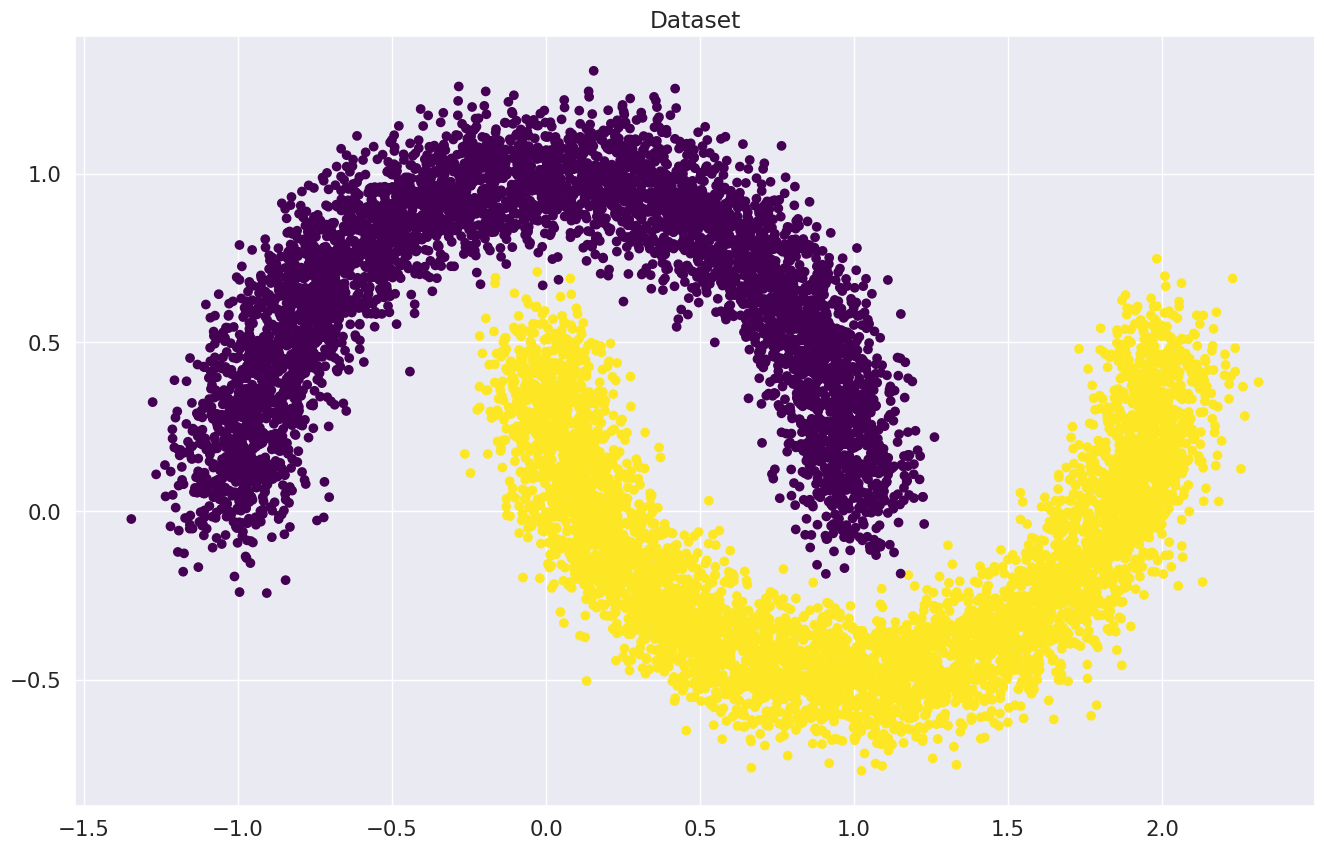

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)


## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [18]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features,1, requires_grad=True))
        self.bias = bias
        if bias:
            self.bias_term = torch.randn(out_features, 1, requires_grad=True)

    def forward(self, x):
        x = x @ self.weights 
        if self.bias:
            x += self.bias_term
        return x

In [19]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [9]:
#Обучающие параметры - количество весов и смещений bias (если есть), количество весов равно in_features, b out_features
#Соответственно в нашем случае при in_features = 2, out = 1 получаем: 3 обучающих параметра

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [20]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch)
        loss = torch.mean((outp - y_batch)**2)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5078125
Iteration: 100
Batch accuracy: 0.296875

Iteration: 122.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 122

### Визуализируем результаты

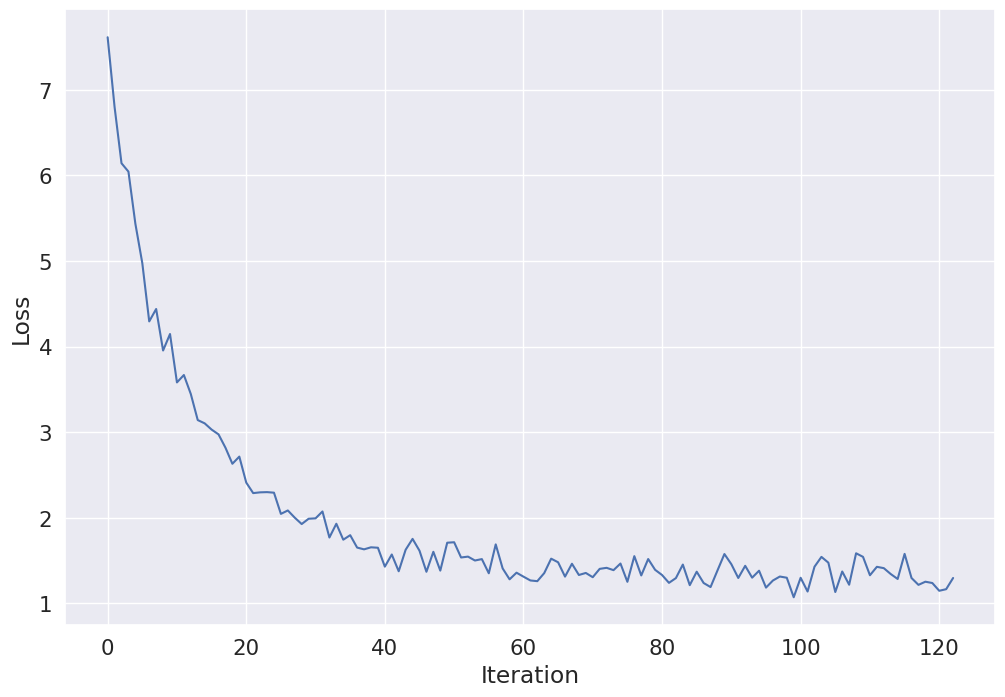

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

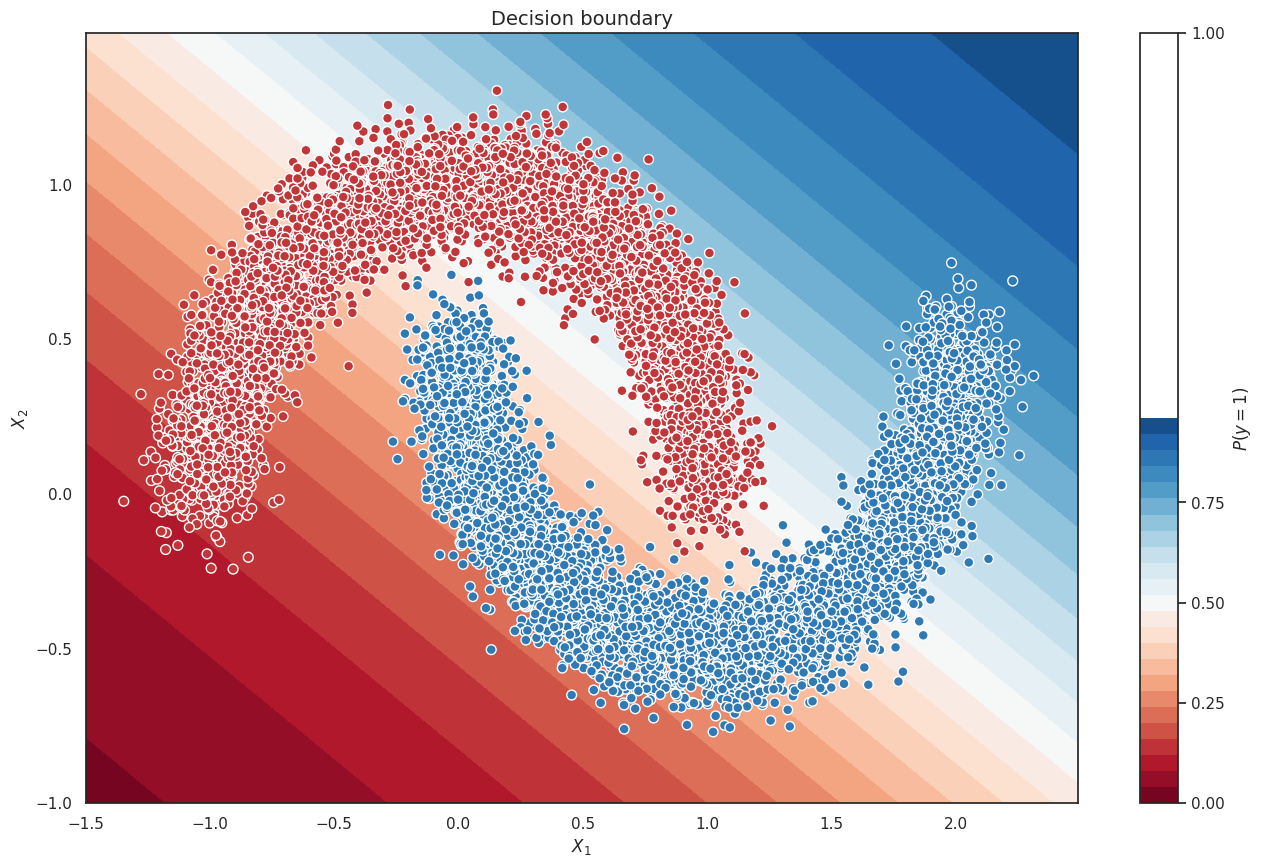

In [22]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [23]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = np.around(model.forward(x_batch))
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [24]:
from sklearn.metrics import accuracy_score

pred = predict(val_dataloader, linear_regression)
accuracy_score(y_val_t, pred)

0.376

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.376

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [25]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './data'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 91467058.66it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35071133.13it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26404090.47it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14976830.79it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [26]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [27]:
activation = nn.ELU
D_in, H, D_out = 784, 128, 10
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D_in, H),
    nn.ELU(),
    nn.Linear(H, H),
    nn.ELU(),
    nn.Linear(H, D_out)
)
loss_fn = nn.CrossEntropyLoss()

In [28]:
criterion = loss_fn
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [30]:
max_epochs = 10
correct = 0
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)
            preds = outp.argmax(-1)
            for i in range(len(preds)):
              if preds[i] == y_batch[i]:
                correct += 1
            all = len(y_batch)
            epoch_correct = correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8900833333333333
Loader: valid. Accuracy: 0.9339
Epoch: 2
Loader: train. Accuracy: 0.9494
Loader: valid. Accuracy: 0.9596
Epoch: 3
Loader: train. Accuracy: 0.9620833333333333
Loader: valid. Accuracy: 0.9641
Epoch: 4
Loader: train. Accuracy: 0.97105
Loader: valid. Accuracy: 0.973
Epoch: 5
Loader: train. Accuracy: 0.9755166666666667
Loader: valid. Accuracy: 0.9731
Epoch: 6
Loader: train. Accuracy: 0.9788666666666667
Loader: valid. Accuracy: 0.9748
Epoch: 7
Loader: train. Accuracy: 0.9822333333333333
Loader: valid. Accuracy: 0.9774
Epoch: 8
Loader: train. Accuracy: 0.9832833333333333
Loader: valid. Accuracy: 0.9753
Epoch: 9
Loader: train. Accuracy: 0.9853333333333333
Loader: valid. Accuracy: 0.9711
Epoch: 10
Loader: train. Accuracy: 0.9875666666666667
Loader: valid. Accuracy: 0.9759


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [31]:
elu_accuracy = accuracy["valid"]

In [35]:
D_in, H, D_out = 784, 128, 10
model_plain = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D_in, H),
    nn.Linear(H, H),
    nn.Linear(H, D_out)
)
model_relu = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, D_out)
)
model_leaky = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D_in, H),
    nn.LeakyReLU(),
    nn.Linear(H, H),
    nn.LeakyReLU(),
    nn.Linear(H, D_out)
)
optimizer_plain = torch.optim.Adam(model_plain.parameters())
optimizer_relu = torch.optim.Adam(model_relu.parameters())
optimizer_leaky = torch.optim.Adam(model_leaky.parameters())
def test_activation_function(switch):
    max_epochs = 10
    correct = 0
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              if k == "train":
                if switch == 1:
                  model_relu.train()
                  outp = model_relu(x_batch)
                  optimizer_relu.zero_grad()
                if switch == 2:
                  model_leaky.train()
                  outp = model_leaky(x_batch)
                  optimizer_leaky.zero_grad()
                else:
                  model_plain.train()
                  outp = model_plain(x_batch)
                  optimizer_plain.zero_grad()
              else:
                with torch.no_grad():
                  if switch == 1:
                   model_relu.eval()
                   outp = model_relu(x_batch)
                  if switch == 2:
                    model_leaky.eval()
                    outp = model_leaky(x_batch)
                  else:
                    model_plain.eval()
                    outp = model_plain(x_batch)
              preds = outp.argmax(-1)
              for i in range(len(preds)):
                if preds[i] == y_batch[i]:
                  correct += 1
              all = len(y_batch)
              epoch_correct = correct
              epoch_all += all
              if k == "train":
                 loss = criterion(outp, y_batch)
                 loss.backward()
                 if switch == 1:
                   optimizer_relu.step()
                 if switch == 2:
                   optimizer_leaky.step()
                 else:
                   optimizer_plain.step()
          if k == "train":
              print(f"Epoch: {epoch+1}")
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

In [36]:
plain_accuracy = test_activation_function(0)
relu_accuracy = test_activation_function(1)
leaky_relu_accuracy = test_activation_function(2)

Epoch: 1
Loader: train. Accuracy: 0.8740666666666667
Loader: valid. Accuracy: 0.9107
Epoch: 2
Loader: train. Accuracy: 0.9011
Loader: valid. Accuracy: 0.9145
Epoch: 3
Loader: train. Accuracy: 0.9073
Loader: valid. Accuracy: 0.9153
Epoch: 4
Loader: train. Accuracy: 0.9091666666666667
Loader: valid. Accuracy: 0.9133
Epoch: 5
Loader: train. Accuracy: 0.9125333333333333
Loader: valid. Accuracy: 0.9132
Epoch: 6
Loader: train. Accuracy: 0.9130666666666667
Loader: valid. Accuracy: 0.9112
Epoch: 7
Loader: train. Accuracy: 0.9124166666666667
Loader: valid. Accuracy: 0.9149
Epoch: 8
Loader: train. Accuracy: 0.9139666666666667
Loader: valid. Accuracy: 0.9043
Epoch: 9
Loader: train. Accuracy: 0.9148333333333334
Loader: valid. Accuracy: 0.9132
Epoch: 10
Loader: train. Accuracy: 0.9160833333333334
Loader: valid. Accuracy: 0.9153
Epoch: 1
Loader: train. Accuracy: 0.91655
Loader: valid. Accuracy: 0.9065
Epoch: 2
Loader: train. Accuracy: 0.9159666666666667
Loader: valid. Accuracy: 0.9161
Epoch: 3
Loade

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

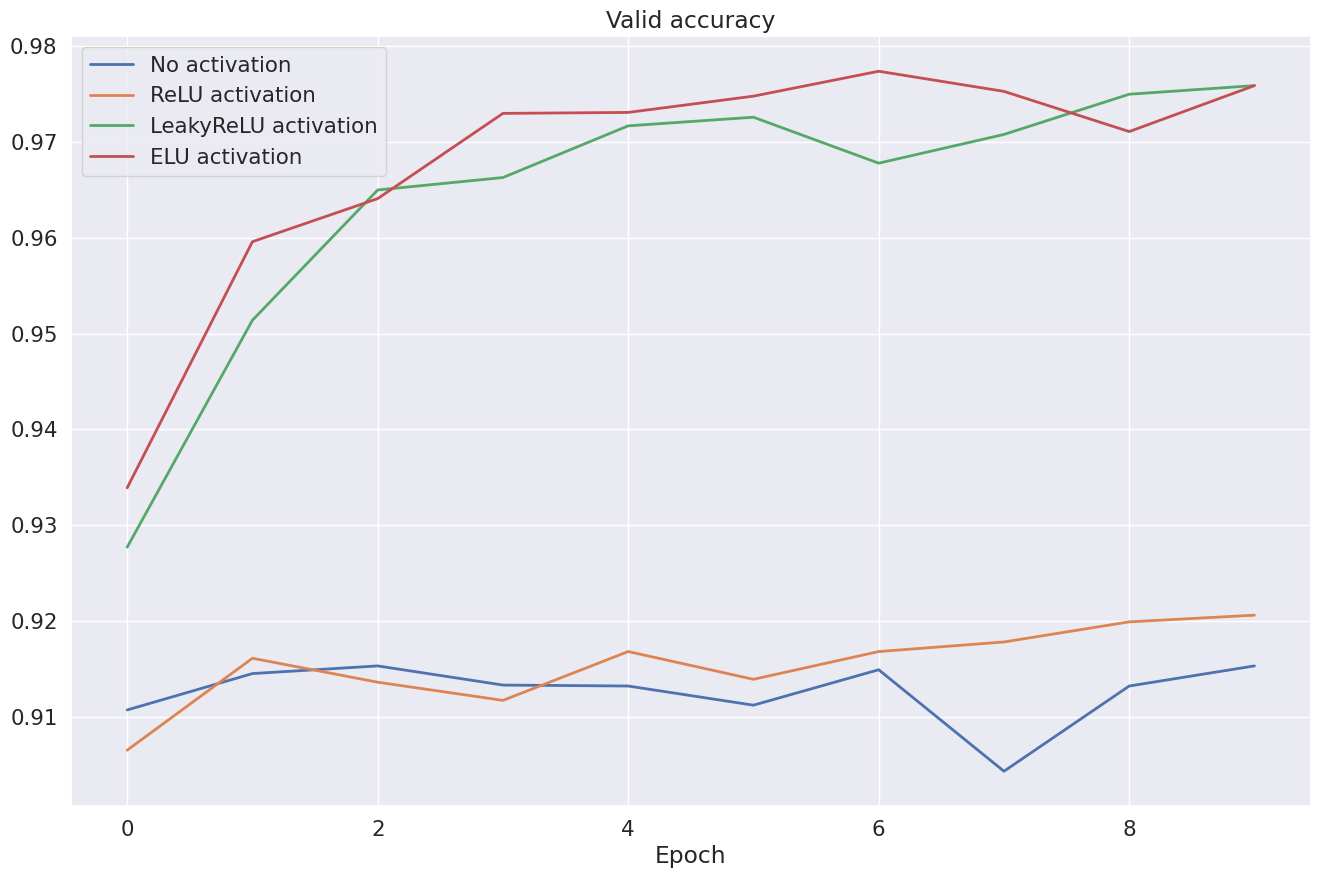

In [37]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

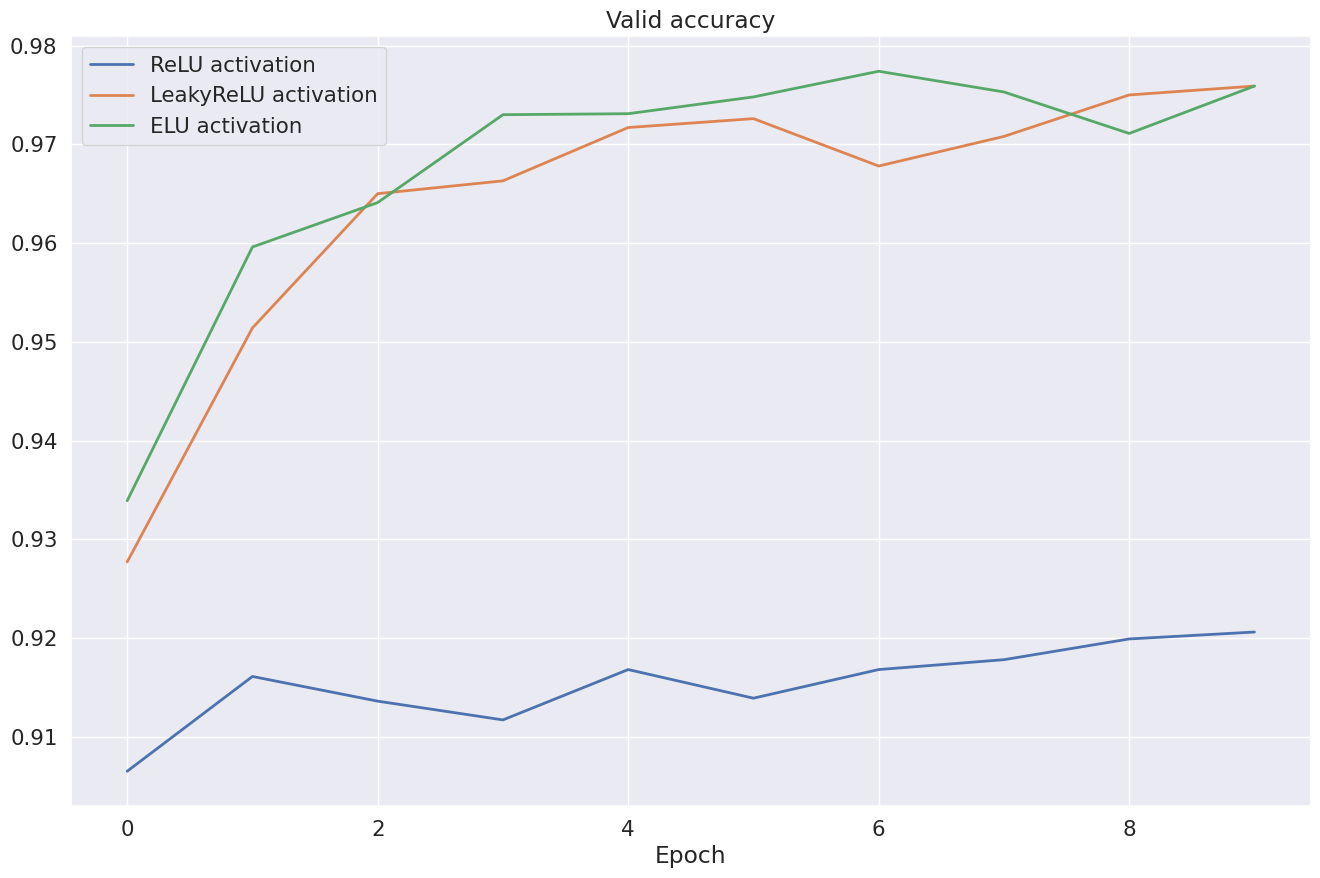

In [38]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU активация показывала лучший результат на протяжении всего цикла обучения, однако к концу сравлялась с Leaky_ReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [39]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-04-03 17:31:36--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2023-04-03 17:31:37--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 104.21.1.92, 172.67.128.246, 2606:4700:3030::6815:15c, ...
Connecting to img.the-village-kz.com (img.the-village-kz.com)|104.21.1.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.01s   

2023-04-03 17:31:37 (4.

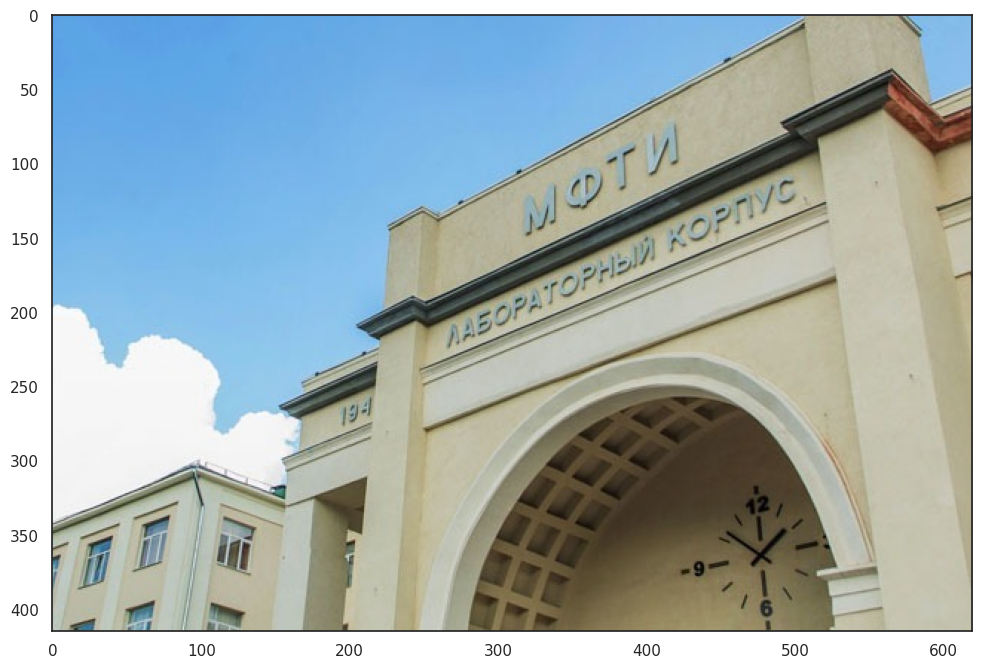

In [40]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [71]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 1],
    [0, -1, 0],
    [1, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

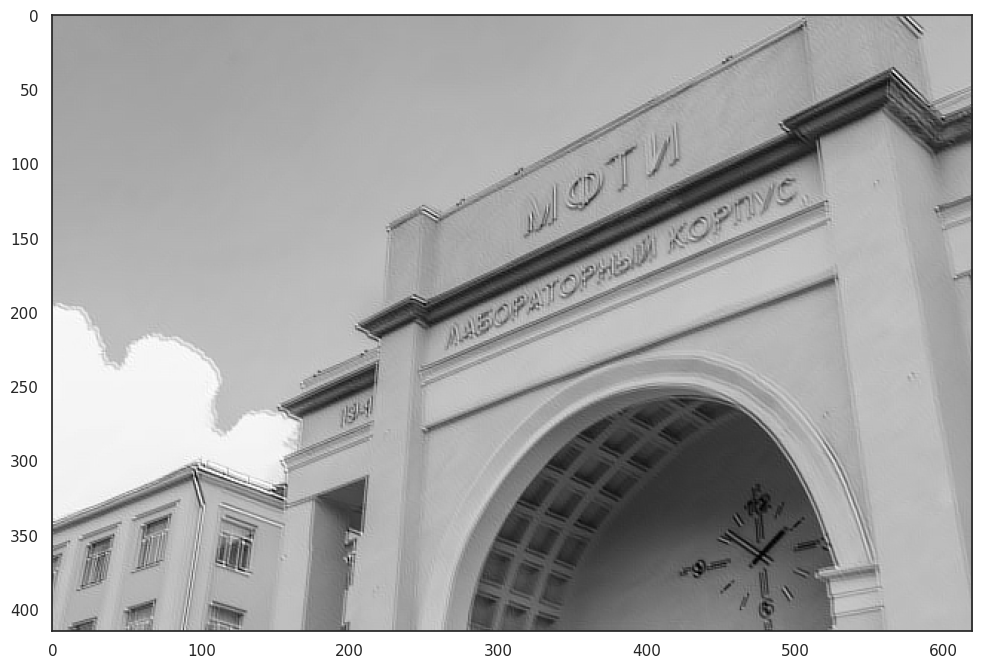

In [72]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие - Е

2) Увеличение резкости - Д

3) Тождественное преобразование - А

4) Выделение вертикальных границ - В

5) Выделение горизонтальных границ - Б

6) Выделение границ - Г

**Ответ:** 1 - Е, 2 - Д, 3 - А, 4 - В, 5 - Б, 6 - Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [86]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [87]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [88]:
max_epochs = 10
correct = 0
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)
            preds = outp.argmax(-1)
            for i in range(len(preds)):
              if preds[i] == y_batch[i]:
                correct += 1
            all = len(y_batch)
            epoch_correct = correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.88905
Loader: valid. Accuracy: 0.97
Epoch: 2
Loader: train. Accuracy: 0.9727
Loader: valid. Accuracy: 0.9806
Epoch: 3
Loader: train. Accuracy: 0.9806666666666667
Loader: valid. Accuracy: 0.9821
Epoch: 4
Loader: train. Accuracy: 0.9855833333333334
Loader: valid. Accuracy: 0.9845
Epoch: 5
Loader: train. Accuracy: 0.9877333333333334
Loader: valid. Accuracy: 0.9874
Epoch: 6
Loader: train. Accuracy: 0.98955
Loader: valid. Accuracy: 0.9881
Epoch: 7
Loader: train. Accuracy: 0.9906666666666667
Loader: valid. Accuracy: 0.9872
Epoch: 8
Loader: train. Accuracy: 0.99165
Loader: valid. Accuracy: 0.9884
Epoch: 9
Loader: train. Accuracy: 0.99285
Loader: valid. Accuracy: 0.9886
Epoch: 10
Loader: train. Accuracy: 0.9940166666666667
Loader: valid. Accuracy: 0.9897


In [89]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

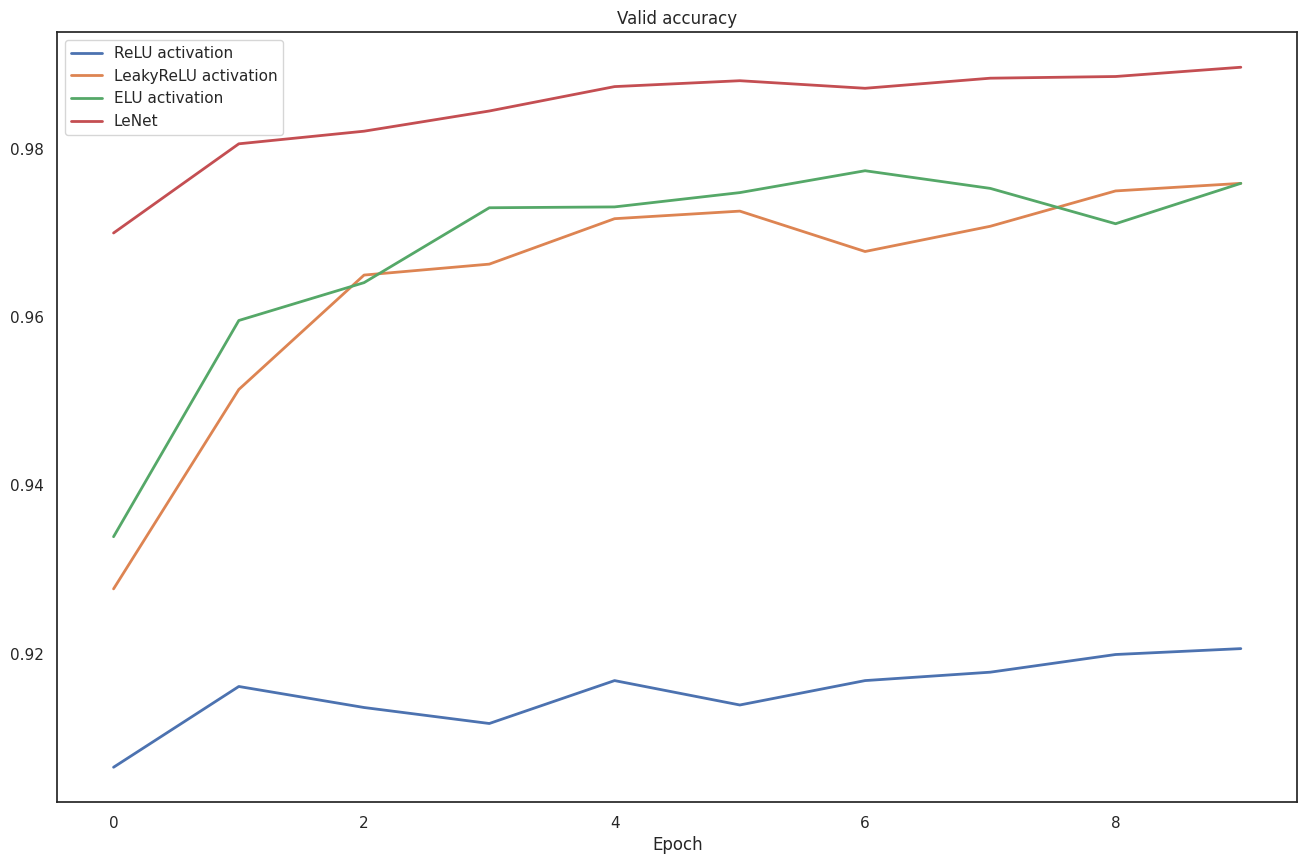

In [90]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99